In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, SimpleRNN, Dropout, LSTM
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

CARGAR EL DF

In [2]:
df = pd.read_csv("weatherAUS.csv")

CAMBIAMOS LAS COLUMNAS RAINTODAY Y RAIN TOMORROW, QUE ESTAN CON "YES" Y "NO" A 1 Y 0 

In [3]:
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': int(1), 'No': int(0)})
df['RainToday'] = df['RainToday'].map({'Yes': int(1), 'No': int(0)})

BORRAMOS LOS NULOS EN 0, Y LOS DEJAMOS PARA EN 1 PARA NO PERDER ESTOS DATOS

In [4]:
df1 = df[df["RainTomorrow"]==1]
df2 = df[df["RainTomorrow"]==0].dropna()

UNIMOS LOS DF CON LOS RESULTADOS ANTERIORES

In [5]:
df = pd.concat([df1,df2],ignore_index=True)

PONEMOS LA COLUMNA DATE COMO DATETIME

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

ELIMINAMOS COLUMNAS QUE NO APORTABAN INFORMACIÓN AL MODELO

In [7]:
df.drop(["WindGustDir","WindDir9am","WindDir3pm"], axis = 1, inplace=True)

CREAMOS UNA FUNCIÓN QUE TRANSFORMA LAS COLUMNAS A NUMERICAS PARA PODER INTRODUCILAS EN KNNIMPUTER

In [8]:
def convertir_a_numerico(df, columnas):
    for columna in columnas:
        try:
            df[columna] = pd.to_numeric(df[columna], errors='coerce')
        except:
            pass
    return df

columnas_a_convertir = df.columns[2:]

df = convertir_a_numerico(df, columnas_a_convertir)

GUARDAMOS LOCATION Y DATE EN UN DATAFRAME, YA QUE ESTAS SON CATEGORICAS Y NO SON CORRECTAS PARA EL KNNIMPUTER

In [9]:
df_Location = pd.DataFrame({"Location":df["Location"]})
df_Date = pd.DataFrame({"Date":df["Date"]})

CREAMOS UN DF CON VALORES FLOAT O INT, Y APLICAMOS KNNIMPUTER

In [10]:
df_num = df.select_dtypes(include=['float64', 'int64'])
columnas = df_num.columns
imputer = KNNImputer(n_neighbors = 3) 
df_imp = imputer.fit_transform(df_num) 

df = pd.DataFrame(data = df_imp, columns = columnas)

AL DF CONSEGUIDO DE KNNIMPUTER SE CONCATENAMOS LAS COLUMNAS DE DATE Y LOCATION

In [11]:
df = pd.concat([df,df_Location,df_Date], axis = 1)

FILTRAMOS LAS CIUDADES QUE TENGAN MENOS DE 6 AÑOS DE DATOS Y LAS ELIMINAMOS

In [12]:
for ciudad in df.Location.unique():
    if (abs(int((df[df["Location"] == ciudad]["Date"].min() - df[df["Location"] == ciudad]["Date"].max()).days))/365) < 6:
        df = df.drop(df[df["Location"] == ciudad].index)

NOS QUEDAMOS CON LAS FECHAS MINIMAS Y MAXIMAS COMPARTIDAS POR TODAS LAS CIUDADES

In [13]:
primera_fecha = max([df[df['Location'] == ciudad].Date.min() for ciudad in df['Location'].unique()])
final_fecha = min([df[df['Location'] == ciudad].Date.max() for ciudad in df['Location'].unique()])
df = df[df.Date >= primera_fecha]
df = df[df.Date <= final_fecha]

PONEMOS LA COLUMNA DATE COMO INDICE

In [14]:
df.set_index('Date', inplace=True)

CREAMOS LAS COLUMNAS AÑO Y MES PARA ORDENAR POR ESAS COLUMNAS

In [15]:
df["Año"] = df.index.year
df["Mes"] = df.index.month

df_sorted = df.sort_values(by=["Año", "Mes"])

df_sorted.drop(['Año', 'Mes'], axis=1, inplace=True)

PONEMOS LA COLUMNA RAINTOMORROW AL FINAL DEL DF, YA QUE SE DIVIDEN LOS DATOS POR INDICE DE LAS COLUMNAS Y ESTA ES LA QUE VAMOS A PREDECIR

In [16]:
columnas_sin_raintomorrow = [col for col in df_sorted.columns if col != 'RainTomorrow']

nuevo_orden_columnas = columnas_sin_raintomorrow + ['RainTomorrow']
df_sorted = df_sorted[nuevo_orden_columnas]

In [21]:
#creamos el df_predicciones sobre el que vamos a trabajar
df_prediccion = df_sorted.select_dtypes(include=['float64', 'int64'])

#creamos el np.array de train con el 80% de los datos
train = np.array(df_prediccion[0:int(len(df_prediccion)*0.8)])

#trabajamos con un lag de 10 dias por fecha
T = 10 # Segmentos
X_train = list()
y_train = list()

for t in range(len(train) - T):

    
    # Toma valores de X_test de t en t con stride de 1
    x_train = train[t : t + T][:-1]
    X_train.append(x_train)

    # Toma los valores de t en t
    y_train_ = train[t + T][-1]
    y_train.append(int(y_train_))

# Transformamos a np.array y ajustamos las dimensiones
# Para entrar en el modelo debe de tener 3 dimensiones
X_train = np.array(X_train)
y_train = np.array(y_train)



#creamos el np.array de test con el 20% de los datos
test = np.array(df_prediccion[int(len(df_prediccion)*0.8):-1])
X_test = list()
y_test = list()

#trabajamos con un lag de 10 dias por fecha
for t in range(len(test) - T):

    # Toma valores de X_test de t en t con stride de 1
    x_test = test[t : t + T][:-1]
    X_test.append(x_test)

    # Toma los valores de t en t
    y_test_ = test[t + T][-1]
    y_test.append(int(y_test_))

# Transformamos a np.array y ajustamos las dimensiones
# Para entrar en el modelo debe de tener 3 dimensiones
X_test = np.array(X_test)
y_test = np.array(y_test)



#creamos un modelo modelo LSTM para predecir la lluvia, con diferentes capas densas y que medirá el accurazy y roc-auc
model = Sequential()

model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=512, activation="relu"))
model.add(Dense(units=256, activation="relu"))
model.add(Dense(units=128, activation="relu"))
model.add(Dense(units=64, activation="relu"))
model.add(Dense(units=32, activation="relu"))
model.add(Dense(units=1, activation="sigmoid")) 

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", AUC()])

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), )




y_pred_decimal = model.predict(X_test)


threshold = 0.5
y_pred = (y_pred_decimal > threshold).astype(int)


accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

roc_auc = roc_auc_score(y_test, y_pred)
print(f'AUC-ROC Score: {roc_auc}')

Epoch 1/10
857/857 [==============================] - 25s 27ms/step - loss: 0.6609 - accuracy: 0.8203 - auc_3: 0.8732 - val_loss: 0.1927 - val_accuracy: 0.9361 - val_auc_3: 0.9786
Epoch 2/10
857/857 [==============================] - 23s 27ms/step - loss: 0.1541 - accuracy: 0.9504 - auc_3: 0.9821 - val_loss: 0.3466 - val_accuracy: 0.8775 - val_auc_3: 0.9805
Epoch 3/10
857/857 [==============================] - 23s 26ms/step - loss: 0.1588 - accuracy: 0.9473 - auc_3: 0.9814 - val_loss: 0.1834 - val_accuracy: 0.9387 - val_auc_3: 0.9877
Epoch 4/10
857/857 [==============================] - 22s 26ms/step - loss: 0.1004 - accuracy: 0.9706 - auc_3: 0.9897 - val_loss: 0.0981 - val_accuracy: 0.9729 - val_auc_3: 0.9911
Epoch 5/10
857/857 [==============================] - 22s 26ms/step - loss: 0.1013 - accuracy: 0.9691 - auc_3: 0.9900 - val_loss: 0.1027 - val_accuracy: 0.9714 - val_auc_3: 0.9901
Epoch 6/10
857/857 [==============================] - 23s 26ms/step - loss: 0.0679 - accuracy: 0.981

CREAMOS LAS LAS GRAFICAS QUE RELACIONAN ACCURACY CON VAL_ACCURACY Y TAMBIEN AUC CON VAL_AUC

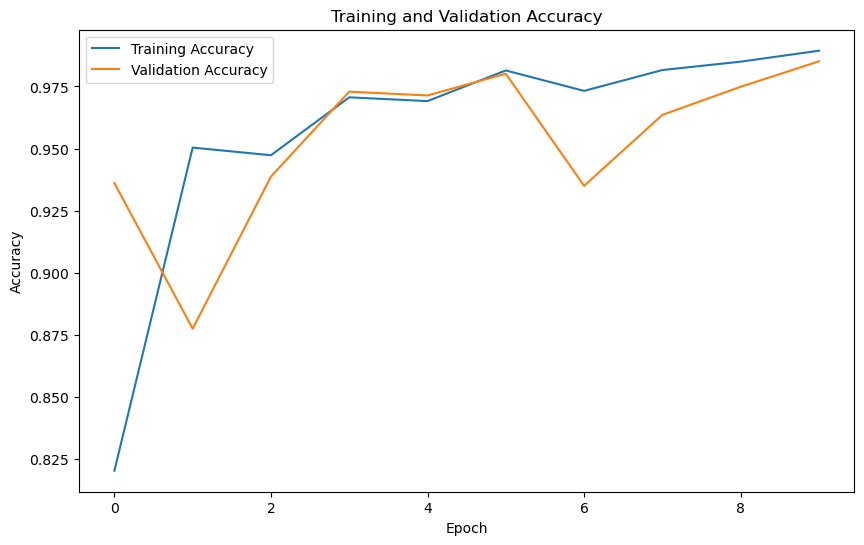

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




GUARDAMOS LOS RESULTADOS EN UN MODELO PICKLE

In [20]:
with open('my_model.pkl', 'wb') as f:
    pickle.dump(model, f)

SE GUARDA EL DF_PREDICCION PARA GRAFICAR SOBRE ESTE

In [22]:
df_prediccion.to_csv('df_prediccion.csv', index=False)

DATOS POR CIUDAD

In [46]:
lista_accuracy = []
lista_roc_auc = []
lista_history = []
lista_ciudad = []
for ciudad in df_sorted["Location"].unique():
    
    df_sorted_ciudad = df_sorted[df_sorted["Location"] == ciudad]
    
    if len(df_sorted_ciudad["RainTomorrow"].unique().tolist()) == 1:
        
        pass
    
    else:
        
        lista_ciudad.append(ciudad)
        #creamos el df_predicciones sobre el que vamos a trabajar
        df_prediccion = df_sorted_ciudad.select_dtypes(include=['float64', 'int64'])

        #creamos el np.array de train con el 80% de los datos
        train = np.array(df_prediccion[0:int(len(df_prediccion)*0.8)])

        #trabajamos con un lag de 10 dias por fecha
        T = 10 # Segmentos
        X_train = list()
        y_train = list()

        for t in range(len(train) - T):


            # Toma valores de X_test de t en t con stride de 1
            x_train = train[t : t + T][:-1]
            X_train.append(x_train)

            # Toma los valores de t en t
            y_train_ = train[t + T][-1]
            y_train.append(int(y_train_))

        # Transformamos a np.array y ajustamos las dimensiones
        # Para entrar en el modelo debe de tener 3 dimensiones
        X_train = np.array(X_train)
        y_train = np.array(y_train)



        #creamos el np.array de test con el 20% de los datos
        test = np.array(df_prediccion[int(len(df_prediccion)*0.8):-1])
        X_test = list()
        y_test = list()

        #trabajamos con un lag de 10 dias por fecha
        for t in range(len(test) - T):

            # Toma valores de X_test de t en t con stride de 1
            x_test = test[t : t + T][:-1]
            X_test.append(x_test)

            # Toma los valores de t en t
            y_test_ = test[t + T][-1]
            y_test.append(int(y_test_))

        # Transformamos a np.array y ajustamos las dimensiones
        # Para entrar en el modelo debe de tener 3 dimensiones
        X_test = np.array(X_test)
        y_test = np.array(y_test)



        #creamos un modelo modelo LSTM para predecir la lluvia, con diferentes capas densas y que medirá el accurazy y roc-auc
        model = Sequential()

        model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
        model.add(LSTM(units=512, activation="relu"))
        model.add(Dense(units=256, activation="relu"))
        model.add(Dense(units=128, activation="relu"))
        model.add(Dense(units=64, activation="relu"))
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=1, activation="sigmoid")) 

        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", AUC()])

        history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), )

        lista_history.append(history)


        y_pred_decimal = model.predict(X_test)


        threshold = 0.5
        y_pred = (y_pred_decimal > threshold).astype(int)


        accuracy = accuracy_score(y_test, y_pred)
        lista_accuracy.append(accuracy)
        print(f'Accuracy: {accuracy}')

        roc_auc = roc_auc_score(y_test, y_pred)
        lista_roc_auc.append(roc_auc)
        print(f'AUC-ROC Score: {roc_auc}')

Epoch 1/10
21/21 [==============================] - 2s 44ms/step - loss: 7.0580 - accuracy: 0.5613 - auc_5: 0.5269 - val_loss: 3.8024 - val_accuracy: 0.1056 - val_auc_5: 0.5243
Epoch 2/10
21/21 [==============================] - 1s 30ms/step - loss: 4.4877 - accuracy: 0.5477 - auc_5: 0.4878 - val_loss: 0.6185 - val_accuracy: 0.8944 - val_auc_5: 0.5474
Epoch 3/10
21/21 [==============================] - 1s 29ms/step - loss: 2.3858 - accuracy: 0.5113 - auc_5: 0.4892 - val_loss: 6.4441 - val_accuracy: 0.1056 - val_auc_5: 0.5000
Epoch 4/10
21/21 [==============================] - 1s 30ms/step - loss: 1.0510 - accuracy: 0.5590 - auc_5: 0.5180 - val_loss: 0.5939 - val_accuracy: 0.7516 - val_auc_5: 0.5767
Epoch 5/10
21/21 [==============================] - 1s 29ms/step - loss: 0.7365 - accuracy: 0.5855 - auc_5: 0.5425 - val_loss: 1.8681 - val_accuracy: 0.1056 - val_auc_5: 0.5899
Epoch 6/10
21/21 [==============================] - 1s 31ms/step - loss: 0.6952 - accuracy: 0.6210 - auc_5: 0.5929 

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [68]:
#Se debe eliminar el ultimo elemento ya que tiene no accuracy y por lo tanto tampoco roc auc.

In [65]:
lista_accuracy.pop(),lista_ciudad.pop(),lista_history.pop()

0.0

In [66]:
df_prediccion_ciudades = pd.DataFrame({"Ciudad":lista_ciudad, "Accuracy":lista_accuracy,"Roc_auc":lista_roc_auc,"history":lista_history})

In [67]:
df_prediccion_ciudades

,Ciudad,Accuracy,Roc_auc,history
0,CoffsHarbour,0.251553,0.503779,<keras.src.callbacks.History object at 0x00000...
1,Moree,0.678191,0.500000,<keras.src.callbacks.History object at 0x00000...
2,NorfolkIsland,0.539877,0.500000,<keras.src.callbacks.History object at 0x00000...
3,Sydney,0.765668,0.500000,<keras.src.callbacks.History object at 0x00000...
4,SydneyAirport,0.767925,0.508000,<keras.src.callbacks.History object at 0x00000...
5,WaggaWagga,0.694268,0.500000,<keras.src.callbacks.History object at 0x00000...
6,Williamtown,0.507246,0.500000,<keras.src.callbacks.History object at 0x00000...
